In [1]:
import os
import warnings
from datetime import datetime, timedelta
from typing import Tuple

import matplotlib.pyplot as plt
import pandas as pd
from dotenv import load_dotenv
from prometheus_api_client import MetricSnapshotDataFrame, MetricRangeDataFrame, PrometheusConnect
from prometheus_api_client.utils import parse_datetime
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5


warnings.filterwarnings('ignore')


load_dotenv()

True

In [ ]:
class BtalertIA:
    def __init__(self, last_minutes_importance: int, regressor=None) -> None:
        """
        Args:
            last_minutes_importance (int): The last minutes that matter to foreacasting (context)
        """
        self.prom = PrometheusConnect(
            url=os.getenv('PROMETHEUS_URL'), disable_ssl=True)
        self.regressor = regressor
        if regressor is None:
            self.regressor = RandomForestRegressor(
                max_depth=40,
                n_estimators=3,
                random_state=123,
            )
        self.forecaster = ForecasterAutoreg(
            regressor=self.regressor,
            lags=self.minutes_to_step(last_minutes_importance)
        )
        self.original_dataframe = pd.DataFrame()
        self.data_train = pd.DataFrame()
        self.data_test = pd.DataFrame()
        self.predictions = pd.Series()
        self.value_column = 'value'
        self.timestamp_column = 'timestamp'

    def load_metric_as_dataframe(self, start: str, end: str, metric_name: str, alias: str) -> pd.DataFrame:
        start_time = parse_datetime(start)
        end_time = parse_datetime(end)
        original_dataframe = MetricRangeDataFrame(
            self.prom.custom_query_range(
                query=metric_name, start_time=start_time, end_time=end_time, step=15)
        )[['value']]

        original_dataframe[self.value_column] = [
            float(value) for value in original_dataframe[self.value_column]]
        
        original_dataframe.rename(columns={'value': alias}, inplace=True)
        self.value_column = alias

        self.original_dataframe = original_dataframe
        return original_dataframe

    def split_test_train_dataframe(self, minutes_split: int) -> Tuple[pd.DataFrame, pd.DataFrame]:
        steps = self.minutes_to_step(minutes_split)

        self.data_train = self.original_dataframe[:-steps]
        self.data_test = self.original_dataframe[-steps:]

        return self.data_train, self.data_test

    def minutes_to_step(self, min: int) -> int:
        return int((min * 60) / 15)

    def train_model(self) -> None:
        self.forecaster.fit(y=self.data_train[self.value_column])

    def predict(self, minutes_prediction: int) -> pd.Series:
        self.predictions = self.forecaster.predict(steps=self.minutes_to_step(minutes_prediction))
        return self.predictions

    def plot_graphic(self):
        fig, ax = plt.subplots(figsize=(18, 12))
        self.data_train[self.value_column].plot(ax=ax, label='train')
        self.data_test[self.value_column].plot(ax=ax, label='test')
        self.predictions.plot(ax=ax, label='predictions')
        ax.legend()

    def get_mean_squared_error(self) -> float:
        error_mse: float = mean_squared_error(
            y_true=self.data_test[self.value_column],
            y_pred=self.predictions
        )
        return error_mse

    def execute(self, start: str, end: str, metric_name: str, minutes_split: int, minutes_prediction: int, alias: str):
        self.load_metric_as_dataframe(start, end, metric_name, alias)
        self.split_test_train_dataframe(minutes_split)
        self.train_model()
        self.predict(minutes_prediction)
# consts
#start = '2022-05-11 07:50:07'
end = '2022-05-11 10:47:27'
start = '2022-05-11 09:53:16'
#end = '2022-05-11 08:03:53'
min_split = 25
# teste
req_failed_ia = BtalertIA(20)

In [ ]:
start_time = parse_datetime(start)
end_time = parse_datetime(end)
original_dataframe = MetricRangeDataFrame(
            req_failed_ia.prom.custom_query_range(
                query='btalert_failed_requests_percent', start_time=start_time, end_time=end_time, step=15)
        )[['value']]
original_dataframe['value'] = [float(v) for v in original_dataframe['value']]
original_dataframe.plot()

In [ ]:
req_failed_ia.original_dataframe['t'] = [datetime.fromtimestamp(tt) for tt in req_failed_ia.original_dataframe.index]
req_failed_ia.original_dataframe['t'] = req_failed_ia.original_dataframe['t'].astype('datetime64[s]')
print(req_failed_ia.original_dataframe['t'])
req_failed_ia.original_dataframe.set_index(req_failed_ia.original_dataframe['t'])
req_failed_ia.original_dataframe.drop(columns='t')
req_failed_ia.original_dataframe.head()

In [ ]:
#req_failed_ia.load_metric_as_dataframe(start, end, 'btalert_failed_requests_percent', 'requests_failed')
#req_failed_ia.value_column = 'requests_failed'
#req_failed_ia.split_test_train_dataframe(min_split)
#req_failed_ia.train_model()
#req_failed_ia.predict(5)
#req_failed_ia.plot_graphic()
req_failed_ia = BtalertIA(10)
req_failed_ia.execute(start, end, 'btalert_failed_requests_percent', 10, 25, 'requests_failed')
req_failed_ia.plot_graphic()

In [ ]:
req_failed = req_failed_ia.load_metric_as_dataframe(start, end, 'btalert_failed_requests_percent', 'req_failed')
requests_per_second = req_failed_ia.load_metric_as_dataframe(start, end, 'btalert_requests_per_second', 'request_per_sec')
#pg_lock_count = req_failed_ia.load_metric_as_dataframe(start, end, 'pg_lock_count')
max_cpu = req_failed_ia.load_metric_as_dataframe(start, end, 'max(rate(container_cpu_usage_seconds_total{image="api6-backend_cadastrol-server"}[1m:15s]))', 'cpu_percent')
memory = req_failed_ia.load_metric_as_dataframe(start, end, 'container_memory_rss{name="cadastrol-server"} / container_spec_memory_limit_bytes{name="cadastrol-server"}', 'memory_percent')

In [ ]:
res = pd.concat([req_failed, requests_per_second, max_cpu, memory], axis=1)
res.head(10)

In [ ]:
res.to_csv('dados.csv', sep=';', encoding='utf-8')

In [ ]:
cor = res.corr()
cor

In [ ]:
import seaborn as sn
plot = sn.heatmap(cor, annot=True, fmt='0.1f', linewidths=.6)
plot

In [ ]:
plot = sn.heatmap(cor, annot=True, fmt='0.1f', linewidths=.6)
plot

### Lendo dados salvos

In [2]:
dados = pd.read_csv('dados.csv', delimiter=';')

In [3]:
dados['timestamp'] = [datetime.fromtimestamp(timestamp) for timestamp in dados['timestamp']]

In [4]:
dados = dados.set_index(dados['timestamp'])
dados = dados.asfreq(freq='15S', method='bfill')

In [22]:
dados.isnull()
dados.fillna(0, inplace=True)
#dados.isnull()

In [23]:
#dados

In [24]:
dados['req_failed'] = dados['req_failed'].div(100)
#dados

In [8]:
def minutes_to_step(min: int) -> int:
        return int((min * 60) / 15)

regressor = RandomForestRegressor(
                max_depth=20,
                n_estimators=3,
                random_state=123,
            )

In [9]:
dados = dados.drop(columns='timestamp')

### Gráfico dos dados de requisições falhadas, uso de CPU(%) e uso de memória(%) dos dados coletados

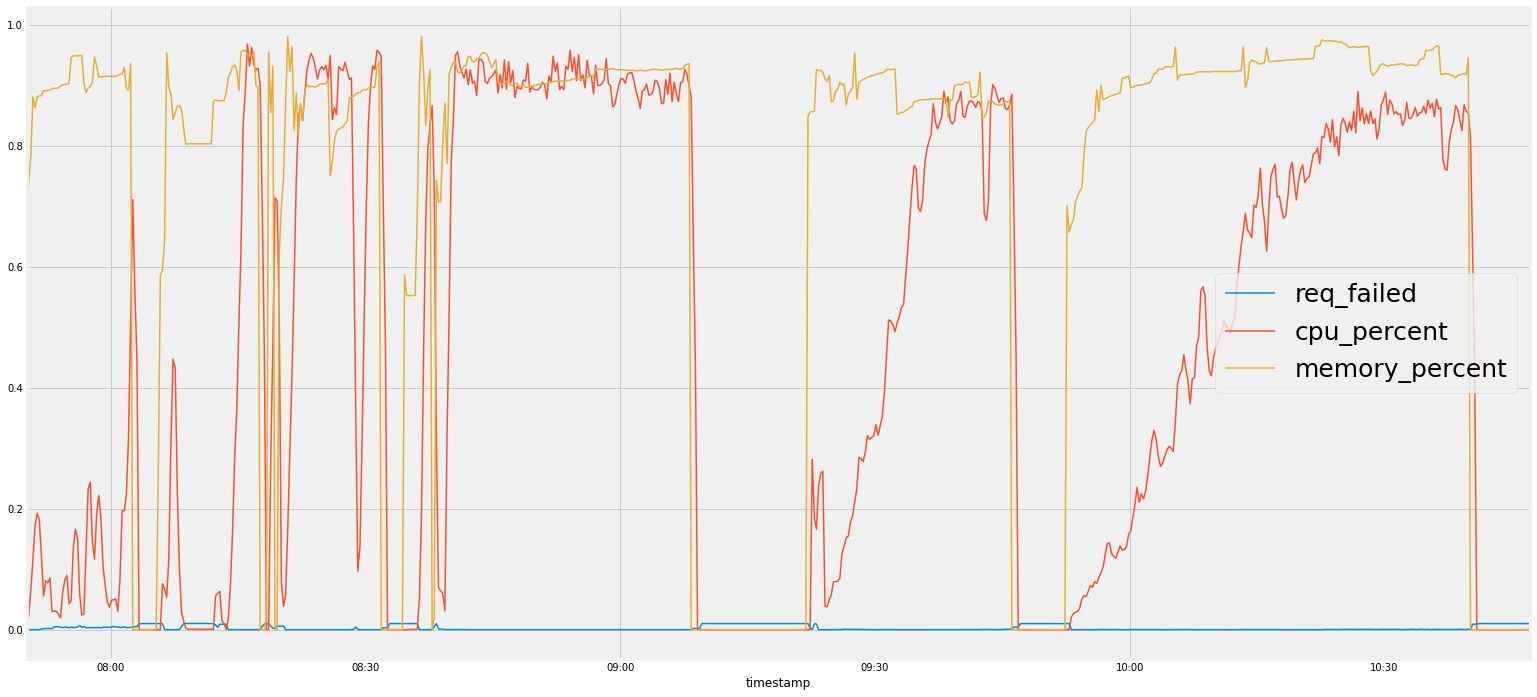

In [40]:
fig, ax = plt.subplots(figsize=(24, 12))
dados['req_failed'].plot(ax=ax, label='req_failed')
dados['cpu_percent'].plot(ax=ax, label='cpu_percent')
dados['memory_percent'].plot(ax=ax, label='memory_percent')

ax.legend(prop={'size': 25})
#dados.plot()

In [12]:
split_time = minutes_to_step(30)
train = dados[:-split_time]
test = dados[-split_time:]

In [25]:
print(len(train), len(test))
#print(train.head())

589 120


In [15]:
predictions = {}
for label in ['req_failed', 'cpu_percent', 'memory_percent', 'request_per_sec']:
    forecaster = ForecasterAutoreg(
            regressor=regressor,
            lags=minutes_to_step(30)
        )
    forecaster.fit(y=train[label])
    prediction = forecaster.predict(steps=split_time)
    predictions[label] = prediction

### Gráfico comparativo da predição VS real das requisições por segundo

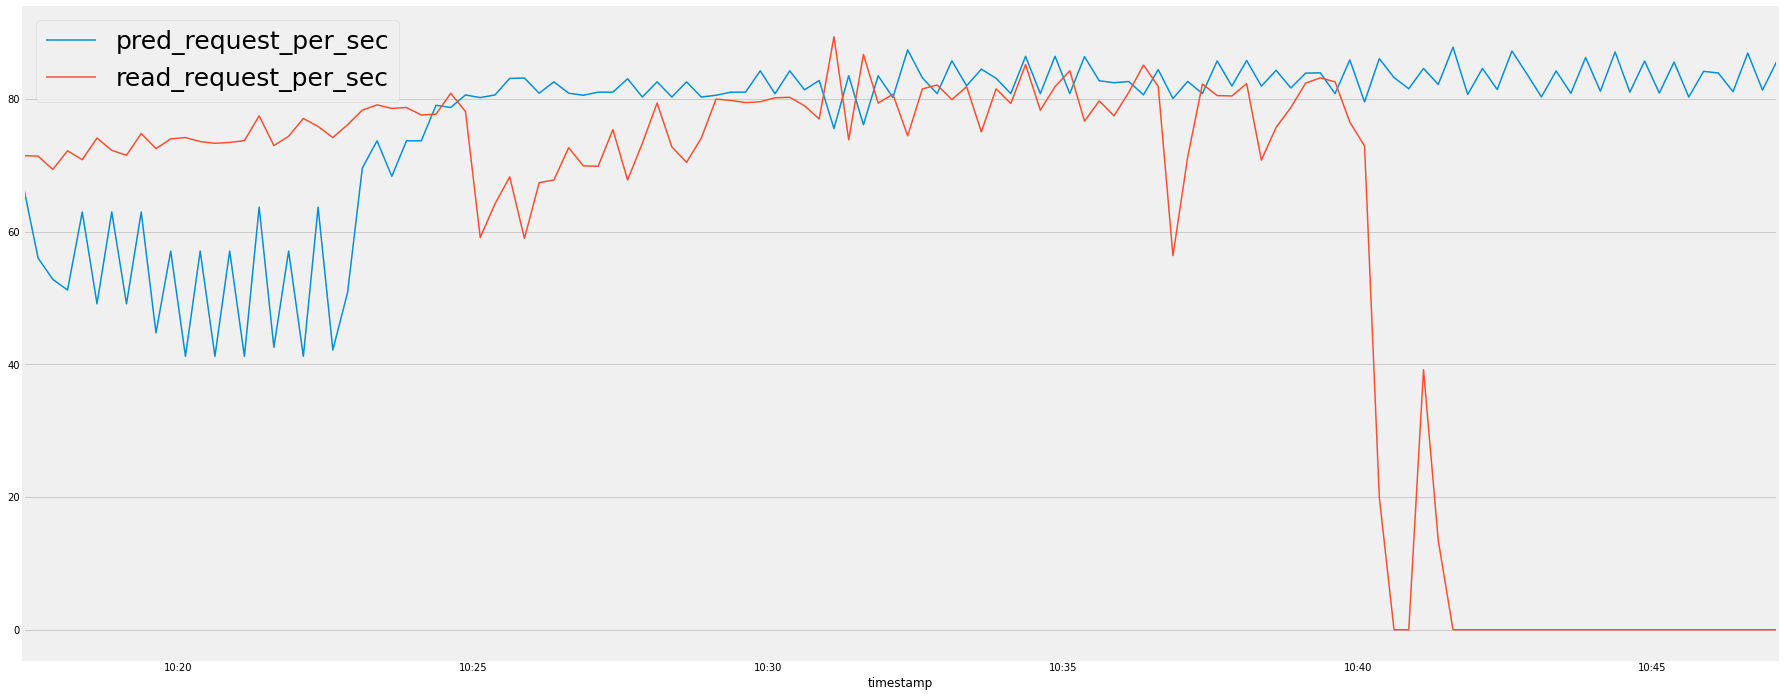

In [31]:
fig, ax = plt.subplots(figsize=(28, 12))
predictions['request_per_sec'].plot(ax=ax, label='pred_request_per_sec')
test['request_per_sec'].plot(ax=ax, label='read_request_per_sec')
ax.legend(prop={'size': 25})

### Gráfico da previsão das requisições falhadas, uso de memória(%) e uso de CPU(%)

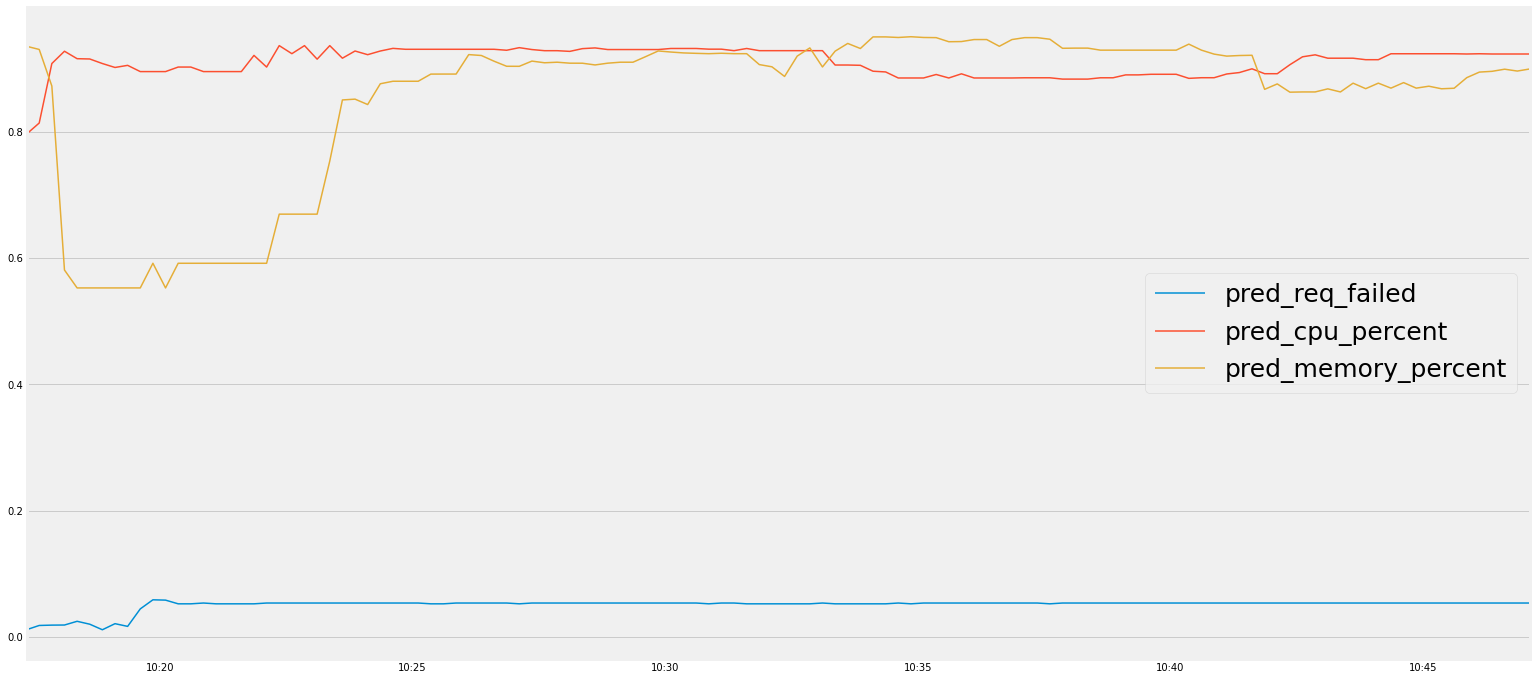

In [39]:
fig, ax = plt.subplots(figsize=(24, 12))
predictions['req_failed'].plot(ax=ax, label='pred_req_failed')
predictions['cpu_percent'].plot(ax=ax, label='pred_cpu_percent')
predictions['memory_percent'].plot(ax=ax, label='pred_memory_percent')
ax.legend(prop={'size': 25})

### Gráfico dos dados reais no mesmo período da previsão

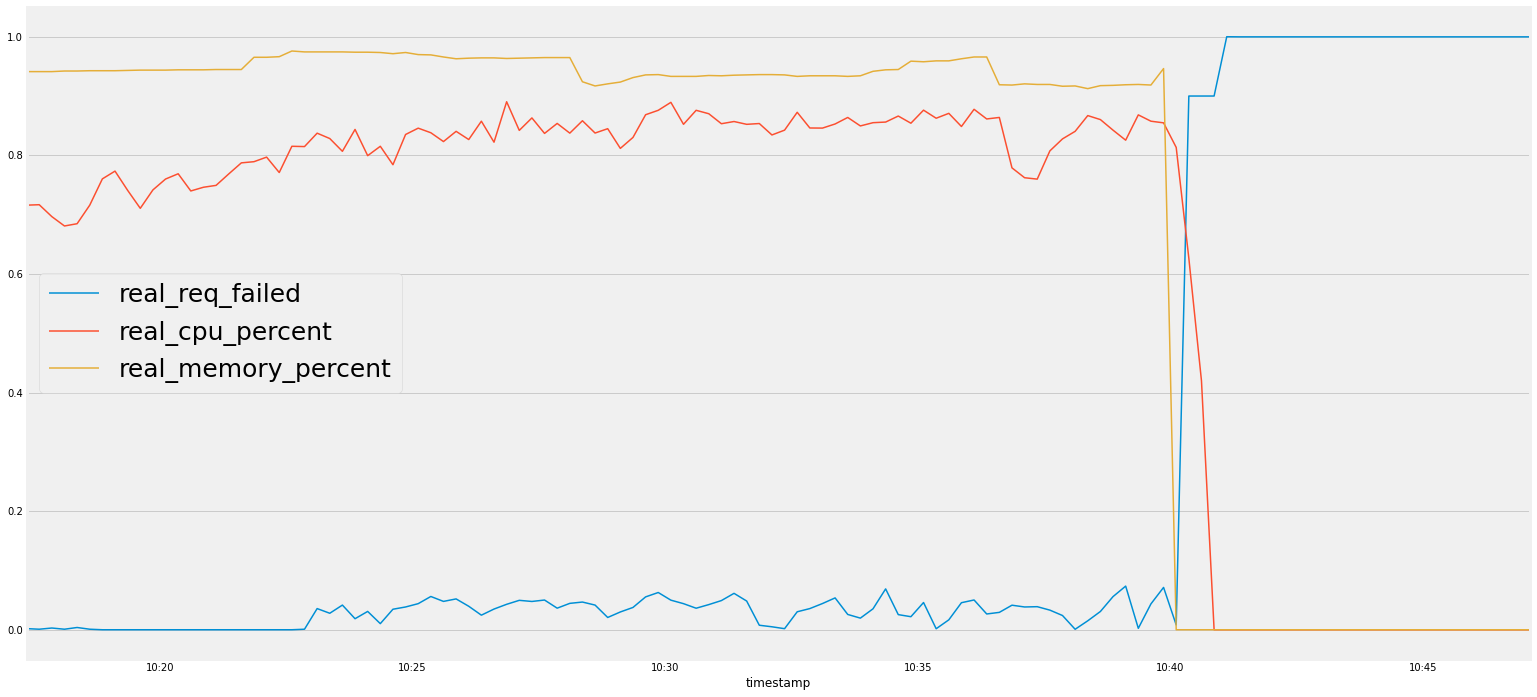

In [38]:
fig, ax = plt.subplots(figsize=(24, 12))
test['req_failed'].plot(ax=ax, label='real_req_failed')
test['cpu_percent'].plot(ax=ax, label='real_cpu_percent')
test['memory_percent'].plot(ax=ax, label='real_memory_percent')
ax.legend(prop={'size': 25})

In [19]:
predictions['req_failed']

2022-05-11 10:17:22    0.011200
2022-05-11 10:17:37    0.017933
2022-05-11 10:17:52    0.018467
2022-05-11 10:18:07    0.018633
2022-05-11 10:18:22    0.024533
                         ...   
2022-05-11 10:46:07    0.053500
2022-05-11 10:46:22    0.053500
2022-05-11 10:46:37    0.053500
2022-05-11 10:46:52    0.053500
2022-05-11 10:47:07    0.053500
Freq: 15S, Name: pred, Length: 120, dtype: float64

In [20]:
res = test
res['pred_req_failed'] = predictions['req_failed']
res['pred_cpu_percent'] = predictions['cpu_percent']
res['pred_memory_percent'] = predictions['memory_percent']
res['diff_req_failed'] = abs(res['pred_req_failed'] - res['req_failed'])
res['diff_cpu_percent'] = abs(res['pred_cpu_percent'] - res['cpu_percent'])
res['diff_memory_percent'] = abs(res['pred_memory_percent'] - res['memory_percent'])

res.head()

,req_failed,request_per_sec,cpu_percent,memory_percent,pred_req_failed,pred_cpu_percent,pred_memory_percent,diff_req_failed,diff_cpu_percent,diff_memory_percent
timestamp,,,,,,,,,,
2022-05-11 10:17:22,0.0019,71.47,0.715967,0.941177,0.011200,0.796951,0.936111,0.009300,0.080984,0.005066
2022-05-11 10:17:37,0.0009,71.40,0.716738,0.941177,0.017933,0.814458,0.931086,0.017033,0.097719,0.010091
2022-05-11 10:17:52,0.0029,69.40,0.696664,0.941177,0.018467,0.908754,0.873113,0.015567,0.212090,0.068064
2022-05-11 10:18:07,0.0009,72.20,0.680872,0.942184,0.018633,0.928250,0.581395,0.017733,0.247378,0.360789
2022-05-11 10:18:22,0.0038,70.87,0.684692,0.942184,0.024533,0.916428,0.553024,0.020733,0.231736,0.389160


In [43]:
desc = res.describe()
desc[['diff_req_failed', 'diff_cpu_percent', 'diff_memory_percent']]

,diff_req_failed,diff_cpu_percent,diff_memory_percent
count,120.000000,120.000000,120.000000
mean,0.236794,0.273211,0.297827
std,0.387729,0.343561,0.357315
min,0.001467,0.008226,0.000605
25%,0.013450,0.067181,0.015687
50%,0.026667,0.105441,0.072281
75%,0.054650,0.217002,0.390671
max,0.946500,0.924254,0.939504
